# Credit Card Fraud

In [77]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
import missingno as miss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve

import warnings
warnings.filterwarnings('ignore')  

from imblearn.over_sampling import SMOTE
import itertools

# Data

In [2]:
data_cr=pd.read_csv(r"./creditcard.csv")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
data_cr.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,1.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,...,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,2.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,...,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0


In [3]:
data_cr.shape

(284807, 31)

In [4]:
data_cr.info()#check data type msno.matrix(data_cr)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

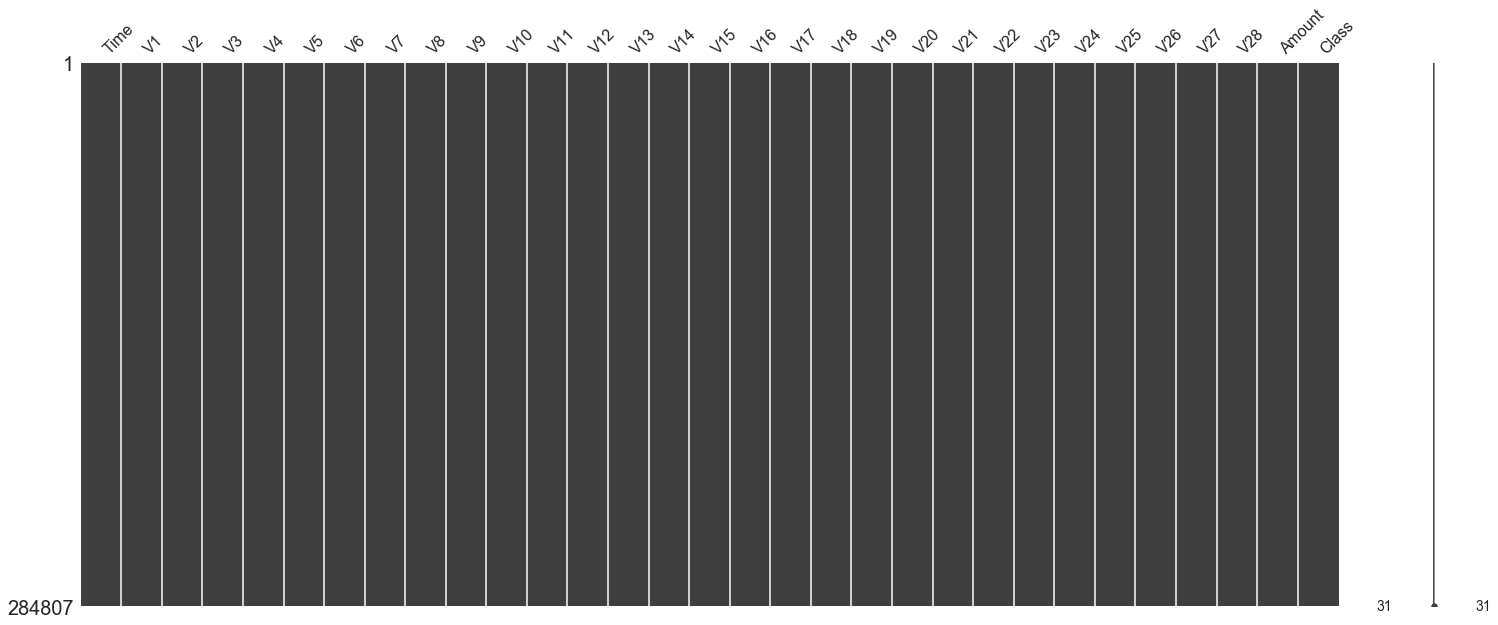

In [5]:
miss.matrix(data_cr) # missing values

data type: float64 and int64，no missing values

# Feature Engineering

Text(0.5,1,'pie chart of the class distribution in the target variable')

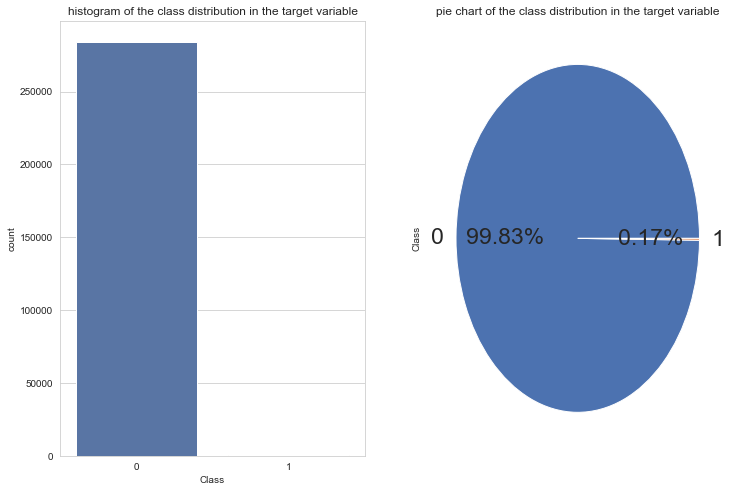

In [6]:
#target variable visulization
fig,ax=plt.subplots(1,2,figsize=(12,8))
sns.set(style="darkgrid")
sns.countplot(x="Class",data=data_cr,ax=ax[0])
ax[0].set_title("histogram of the class distribution in the target variable")
data_cr["Class"].value_counts().plot(kind="pie",ax=ax[1],fontsize=23,autopct='%1.2f%%')
ax[1].set_title("pie chart of the class distribution in the target variable")

In [7]:
data_cr["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

### Therefore this is severely unimbalanced data

In [8]:
data_cr["Time"]=data_cr["Time"].apply(lambda x: divmod(x,3600)[0])

## Feature Selection

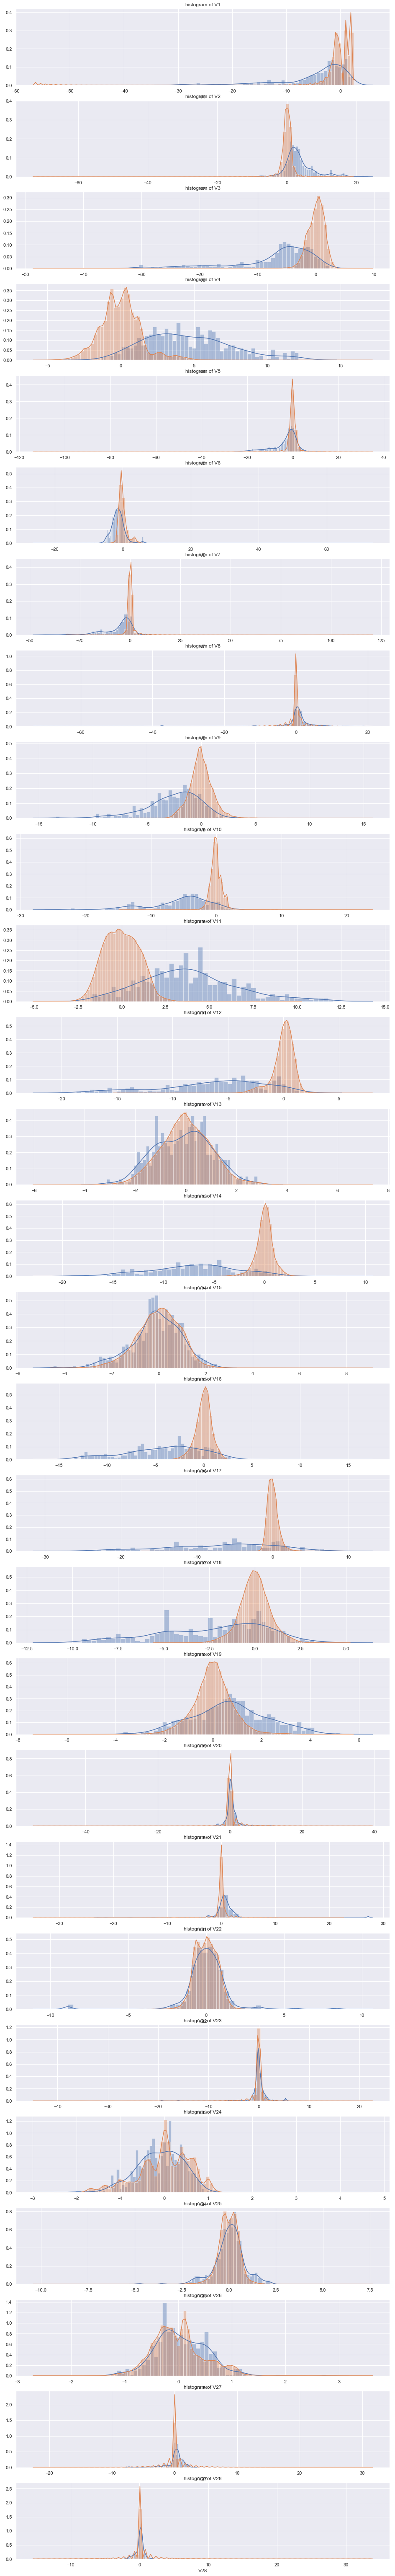

In [9]:
v_feature=data_cr.iloc[:,1:29].columns
plt.figure(figsize=(16,28*4))
gs=gridspec.GridSpec(28,1)
for i,cn in enumerate(v_feature):
    ax=plt.subplot(gs[i])
    sns.distplot(data_cr[cn][data_cr["Class"]==1],bins=50)
    sns.distplot(data_cr[cn][data_cr["Class"]==0],bins=100)   
    ax.set_label("")
    ax.set_title("histogram of "+str(cn))
#plt.savefig("./desktop/histogram.jpg")

The above graphs display the distribution of different variables corresponding to normal and abnormal cases. We need to pick variables that show significant difference in normal and abnormal conditions. Therefore, we omit V8、V13 、V15 、V20、V21 、V22、 V23 、V24 、V25 、V26 、V27 and V28.

In [12]:
droplist=["V8","V13","V15","V20","V21","V22","V23","V24","V25","V26","V27","V28"]#delete less related features
data_new=data_cr.drop(droplist,axis=1)
data_new.shape

(284807, 19)

In [11]:
data_new.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11',
       'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'Amount', 'Class'],
      dtype='object')

## Standarization

In [13]:
data_new

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.364,0.091,-0.552,-0.618,-0.311,-0.470,0.208,0.026,0.404,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,-0.255,-0.167,1.613,1.065,-0.144,0.464,-0.115,-0.183,-0.146,2.690,0
2,0.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,-1.515,0.208,0.625,0.066,-0.166,-2.890,1.110,-0.121,-2.262,378.660,0
3,0.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,-1.387,-0.055,-0.226,0.178,-0.288,-1.060,-0.684,1.966,-1.233,123.500,0
4,0.000,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,0.818,0.753,-0.823,0.538,-1.120,-0.451,-0.237,-0.038,0.803,69.990,0
5,0.000,-0.426,0.961,1.141,-0.168,0.421,-0.030,0.476,-0.569,-0.371,1.341,0.360,-0.137,0.402,-0.058,0.069,-0.033,3.670,0
6,0.000,1.230,0.141,0.045,1.203,0.192,0.273,-0.005,0.465,-0.099,-1.417,-0.154,0.167,-0.444,0.003,-0.612,-0.046,4.990,0
7,0.000,-0.644,1.418,1.074,-0.492,0.949,0.428,1.121,0.615,1.249,-0.619,0.291,-1.324,-0.076,-1.222,-0.358,0.325,40.800,0
8,0.000,-0.894,0.286,-0.113,-0.272,2.670,3.722,0.370,-0.392,-0.410,-0.705,-0.110,0.074,-0.210,-0.500,0.119,0.570,93.200,0
9,0.000,-0.338,1.120,1.044,-0.222,0.499,-0.247,0.652,-0.737,-0.367,1.018,0.836,-0.444,0.739,-0.541,0.477,0.452,3.680,0


In [14]:
col=["Amount","Time"]
from sklearn.preprocessing import StandardScaler
data_new[col]=StandardScaler().fit_transform(data_new[col])
data_new.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,Amount,Class
0,-1.960,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.364,0.091,-0.552,-0.618,-0.311,-0.470,0.208,0.026,0.404,0.245,0
1,-1.960,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,-0.255,-0.167,1.613,1.065,-0.144,0.464,-0.115,-0.183,-0.146,-0.342,0
2,-1.960,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,-1.515,0.208,0.625,0.066,-0.166,-2.890,1.110,-0.121,-2.262,1.161,0
3,-1.960,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,-1.387,-0.055,-0.226,0.178,-0.288,-1.060,-0.684,1.966,-1.233,0.141,0
4,-1.960,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,0.818,0.753,-0.823,0.538,-1.120,-0.451,-0.237,-0.038,0.803,-0.073,0


## Rank the variables according to their importance for further dimension reduction

(-1, 18)

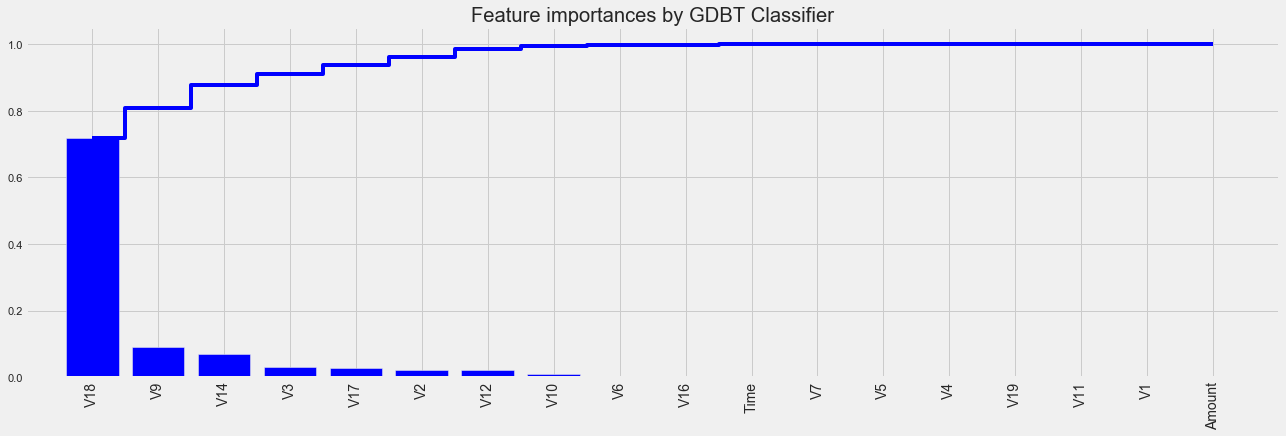

In [15]:
x_val=data_new.iloc[:,:-1]
y_val=data_new.iloc[:,-1]
#rank the variables with GBDT
from sklearn.ensemble import GradientBoostingClassifier as GDBT
clf=GDBT()
clf.fit(x_val,y_val)
#visualize ranking
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)
importance=clf.feature_importances_
feature_name=data_new.columns[:-1]
indices=np.argsort(importance)[::-1]
fig = plt.figure(figsize=(20,6))
plt.title("Feature importances by GDBT Classifier")
plt.bar(range(len(importance)),importance[indices],color="blue",align="center")
plt.step(range(len(importance)),np.cumsum(importance[indices]),color="blue",where="mid",label="cumulative")
plt.xticks(range(len(importance)),feature_name[indices],rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])

In [16]:
droplist1=["Amount","V5","V1","V7","V11","V2","V9","V4","V19","V18","Time"]
data_new1=data_new.drop(droplist1,axis=1)

# Train the Model

# SMOTE 

In [72]:
x_all=data_new1.iloc[:,:-1]
y_all=data_new1.iloc[:,-1]

X_train,X_test,Y_train,Y_test=train_test_split(x_val,y_val,test_size=0.3)
n_samples=len(Y_train)
pos_samples=Y_train[Y_train==1].shape[0]
print("the percentage of fraud before over-sampling {:.2%}".format(pos_samples/n_samples))
#only perform smote on training sample
X_train_new,Y_train_new=SMOTE(random_state=12).fit_sample(X_train,Y_train)
n_samples_new=len(Y_train_new)
pos_samples_new=Y_train_new[Y_train_new==1].shape[0]
print("the percentage of fraud after over-sampling {:.2%}".format(pos_samples_new/n_samples_new))

the percentage of fraud before over-sampling 0.17%
the percentage of fraud after over-sampling 50.00%


Text(0,0.5,'Class')

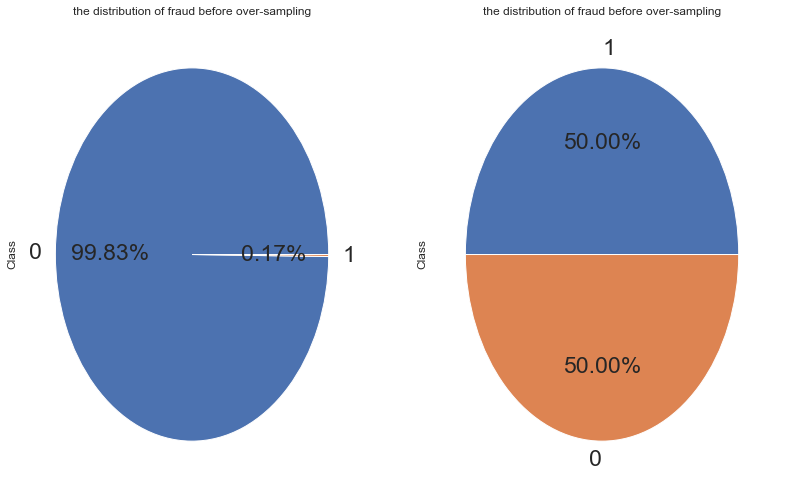

In [51]:
fig,ax=plt.subplots(1,2,figsize=(12,8))
sns.set(style="darkgrid")

data_cr["Class"].value_counts().plot(kind="pie",ax=ax[0],fontsize=23,autopct='%1.2f%%')
ax[0].set_title("the distribution of fraud before over-sampling")
pd.Series(Y_train_new).value_counts().plot(kind="pie",ax=ax[1],fontsize=23,autopct='%1.2f%%')#长度为1，保留百分号前面的2个小数点
ax[1].set_title("the distribution of fraud before over-sampling")
ax[1].set_ylabel("Class")

# Define the function for visulization

In [19]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Logistic regression 

Recall on traing set:  0.9150326797385621


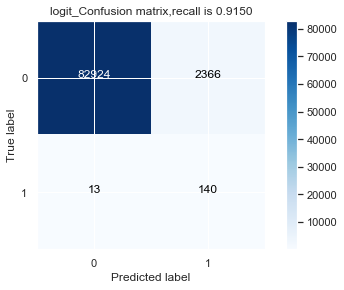

In [59]:
from sklearn.linear_model import LogisticRegression
lg_clf=LogisticRegression()
lg_clf.fit(X_train_new,Y_train_new)
lg_pred=lg_clf.predict(X_test)
cnf_matrix_lg = confusion_matrix(Y_test,lg_pred)  # generate confusion matrix
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure(figsize=(6,4))
plt.subplot(111)
plot_confusion_matrix(cnf_matrix_lg
                      , classes=class_names
                      , title='logit_Confusion matrix,recall is {:.4f}'.format(cnf_matrix_lg[1,1]/(cnf_matrix_lg[1,0]+cnf_matrix_lg[1,1])))
print("Recall on traing set: ", cnf_matrix_lg[1,1]/(cnf_matrix_lg[1,0]+cnf_matrix_lg[1,1]))
# plt.savefig(r"./desktop/logistic regression.jpg",dpi=600)
plt.show()

In [60]:
print(type(X_train_new))
print(type(X_test))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


# tune model parameters based on GridSearchCV and cross-validation

In [23]:
from sklearn.linear_model import LogisticRegression
para_logit= {'C': [100,1,10]}#set of candidate parameters
clf=GridSearchCV(LogisticRegression(dual=True),param_grid=para_logit,cv=10,iid=False,n_jobs=-1)
clf.fit(X_train_new,Y_train_new)
print("best parameters: {}".format(clf.best_params_))
print("score of best cross-validation{:.5f}".format(clf.best_score_))

best parameters: {'C': 1}
score of best cross-validation0.93568


# prediction

In [25]:
y_pred = clf.predict(X_test)
print("accuracy on testing set: {:.5f}".format(accuracy_score(Y_test, y_pred,)))

accuracy on testing set: 0.97328


# visulization of result

logistic regression recall testing set:  0.8958333333333334
GridSearchCV recall on testing set:  0.9027777777777778


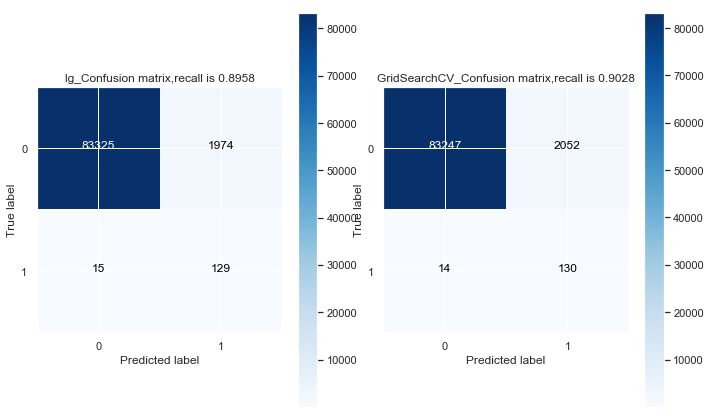

In [23]:
# Compute confusion matrix
cnf_matrix_lg = confusion_matrix(Y_test,lg_pred)  
cnf_matrix_gd = confusion_matrix(Y_test,y_pred)  
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure(figsize=(10,6))
plt.subplot(121)
plot_confusion_matrix(cnf_matrix_lg
                      , classes=class_names
                      , title='lg_Confusion matrix,recall is {:.4f}'.format(cnf_matrix_lg[1,1]/(cnf_matrix_lg[1,0]+cnf_matrix_lg[1,1])))
plt.subplot(122)
plot_confusion_matrix(cnf_matrix_gd
                      , classes=class_names
                      , title='GridSearchCV_Confusion matrix,recall is {:.4f}'.format(cnf_matrix_gd[1,1]/(cnf_matrix_gd[1,0]+cnf_matrix_gd[1,1])))
print("logistic regression recall testing set: ", cnf_matrix_lg[1,1]/(cnf_matrix_lg[1,0]+cnf_matrix_lg[1,1]))
print("GridSearchCV recall on testing set: ", cnf_matrix_gd[1,1]/(cnf_matrix_gd[1,0]+cnf_matrix_gd[1,1]))
plt.show()

In [37]:
#li=[]
#for i in Y_test[Y_test==1].index:
#    li.append(i)
        
#X_test_pos=X_test.loc[li,:]
#Y_test_pos=Y_test[Y_test==1]
#y_pred_pos = clf_lgb.predict(X_test_pos)
#print("accuracy of fraud detection in testing set: {:.5f}".format(accuracy_score(Y_test_pos, y_pred_pos,)))

# Model Evaluation

## set different threshold to adjust the prediction of fraud and subsequently the recall

When threshold is 0.1,  Recall rate is 0.95833,  AUC is 0.85464
When threshold is 0.2,  Recall rate is 0.93750,  AUC is 0.91735
When threshold is 0.3,  Recall rate is 0.91667,  AUC is 0.93028
When threshold is 0.4,  Recall rate is 0.91667,  AUC is 0.94058
When threshold is 0.5,  Recall rate is 0.90278,  AUC is 0.93936
When threshold is 0.6,  Recall rate is 0.88194,  AUC is 0.93253
When threshold is 0.7,  Recall rate is 0.88194,  AUC is 0.93481
When threshold is 0.8,  Recall rate is 0.86111,  AUC is 0.92591
When threshold is 0.9,  Recall rate is 0.83333,  AUC is 0.91357


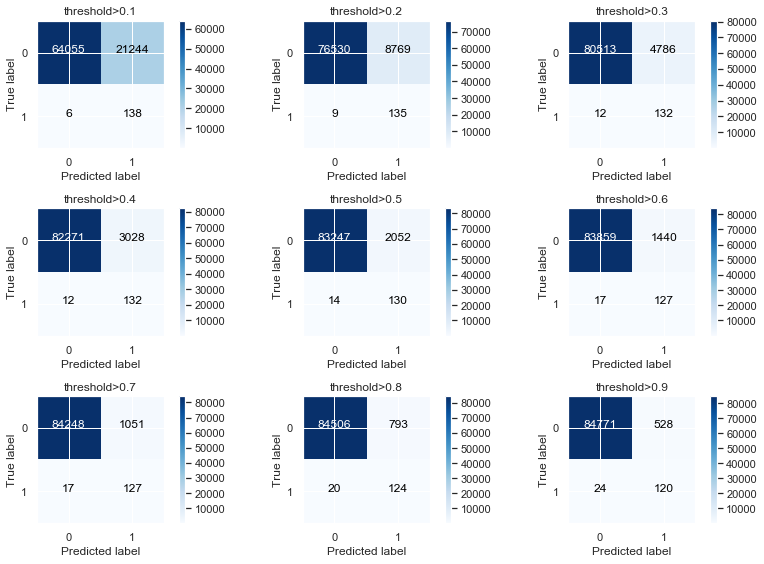

In [24]:
from itertools import cycle
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])
y_pred_proba=clf.predict_proba(X_test)
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(12,8))
j=1
re=[]
pr=[]
a=[]
for i,color in zip(thresholds,colors):
    y_test_predictions_high_recall=y_pred_proba[:,1]>i
    plt.subplot(3,3,j)
    j+=1
    # Compute confusion matrix
    cnf_matrix1 = confusion_matrix(Y_test, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)
    fpr, tpr, _ = roc_curve(Y_test, y_test_predictions_high_recall)
    area = auc(fpr, tpr)
    recall_rate=cnf_matrix1[1,1]/(cnf_matrix1[1,0]+cnf_matrix1[1,1])
    precision_rate=(cnf_matrix1[1,1]+cnf_matrix1[0,0])/(cnf_matrix1.sum())
    print("When threshold is {0},  Recall rate is {1:0.5f},  AUC is {2:.5f}".format(i, recall_rate,area))
    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix1, classes=class_names,title="threshold>{}".format(i)) 
    re.append(recall_rate)
    pr.append(precision_rate)
    a.append(area)

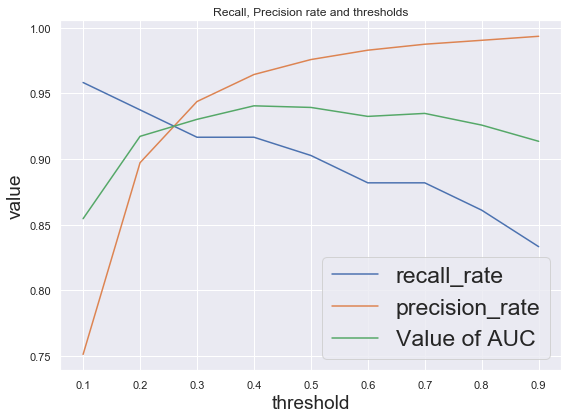

In [25]:
plt.figure(figsize=(8,6))
sns.set()
plt.plot(thresholds,re,label="recall_rate")
plt.plot(thresholds,pr,label="precision_rate")
plt.plot(thresholds,a,label="Value of AUC")
plt.legend(fontsize=23)
plt.xlabel("threshold",fontsize=19)
plt.ylabel("value",fontsize=19)
plt.title("Recall, Precision rate and thresholds")
plt.show()

As the threshold gradually increases, recall decreases and precision increases. AUC first increase and then decrease with a maximum when threshold=0.5

## SVM

In [29]:
from sklearn.svm import SVC
X = data_cr.drop(['Class'], axis = 1).values
Y = data_cr['Class'].values
randomState = 10
np.random.seed(randomState)
X_dtrain, X_deval, Y_dtrain, Y_deval = train_test_split(X,
                                                        Y,
                                                        test_size = 0.3,
                                                        random_state = randomState)
scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    # find the best C parameter
    SVM_param_grid = {'C': [1,10,100,1000]}
    gsearch = GridSearchCV(
        estimator = SVC(tol = 1e-8,
                        class_weight = 'balanced',
                        max_iter = 500),
        param_grid = SVM_param_grid,
        cv = 5,
        scoring='%s_macro' % score,
        n_jobs = -1)
    gsearch.fit(X_dtrain, Y_dtrain.ravel())
        
    print("best parameter: {}".format(gsearch.best_params_))
    print("Grid scores on Training dataset:")
    print()
    means = gsearch.cv_results_['mean_test_score']
    stds = gsearch.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, gsearch.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    y_true_train_svm, y_pred_train_svm = Y_dtrain, gsearch.predict(X_dtrain)
    print(classification_report(y_true_train_svm, y_pred_train_svm))
    print()

# Tuning hyper-parameters for precision

best parameter: {'C': 100}
Grid scores on Training dataset:

0.501 (+/-0.000) for {'C': 1}
0.887 (+/-0.045) for {'C': 10}
0.899 (+/-0.057) for {'C': 100}
0.875 (+/-0.055) for {'C': 1000}

Detailed classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199013
           1       0.95      1.00      0.97       351

   micro avg       1.00      1.00      1.00    199364
   macro avg       0.98      1.00      0.99    199364
weighted avg       1.00      1.00      1.00    199364


# Tuning hyper-parameters for recall

best parameter: {'C': 10}
Grid scores on Training dataset:

0.568 (+/-0.025) for {'C': 1}
0.701 (+/-0.064) for {'C': 10}
0.697 (+/-0.054) for {'C': 100}
0.697 (+/-0.039) for {'C': 1000}

Detailed classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199013
           1       0.95      1.00      0.97

In [28]:
# test kernel
scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    # find the best C parameter
    SVM_param_grid = {'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
    
    gsearch = GridSearchCV(
        estimator = SVC(C = 100,
                        tol = 1e-8,
                        class_weight = 'balanced',
                        max_iter = 500),
        param_grid = SVM_param_grid,
        cv = 5,
        scoring='%s_macro' % score,
        n_jobs = -1)
    gsearch.fit(X_dtrain, Y_dtrain.ravel())
        
    print("best parameter: {}".format(gsearch.best_params_))
    print("Grid scores on Training dataset:")
    print()
    means = gsearch.cv_results_['mean_test_score']
    stds = gsearch.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, gsearch.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    y_true_train_svm, y_pred_train_svm = Y_dtrain, gsearch.predict(X_dtrain)
    print(classification_report(y_true_train_svm, y_pred_train_svm))
    print()


# Tuning hyper-parameters for precision

best parameter: {'kernel': 'rbf'}
Grid scores on Training dataset:

0.899 (+/-0.057) for {'kernel': 'rbf'}
0.500 (+/-0.004) for {'kernel': 'linear'}
0.501 (+/-0.000) for {'kernel': 'poly'}
0.500 (+/-0.001) for {'kernel': 'sigmoid'}

Detailed classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    199013
           1       0.95      1.00      0.97       351

   micro avg       1.00      1.00      1.00    199364
   macro avg       0.98      1.00      0.99    199364
weighted avg       1.00      1.00      1.00    199364


# Tuning hyper-parameters for recall

best parameter: {'kernel': 'rbf'}
Grid scores on Training dataset:

0.697 (+/-0.054) for {'kernel': 'rbf'}
0.481 (+/-0.306) for {'kernel': 'linear'}
0.500 (+/-0.000) for {'kernel': 'poly'}
0.497 (+/-0.107) for {'kernel': 'sigmoid'}

Detailed classification report:

              precision    recall  f1-score   support

      

In [48]:
# test gamma parameters
scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    # find the best C parameter
    SVM_param_grid = {'gamma': list(np.linspace((1/30), 0, 29))}
    gsearch = GridSearchCV(
        estimator = SVC(C = 100,
                        tol = 1e-8,
                        kernel = 'rbf',
                        class_weight = 'balanced',
                        max_iter = 500),
        param_grid = SVM_param_grid,
        cv = 5,
        scoring='%s_macro' % score,
        n_jobs = -1)
    gsearch.fit(X_dtrain, Y_dtrain.ravel())
        
    print("best parameter: {}".format(gsearch.best_params_))
    print("Grid scores on Training dataset:")
    print()
    means = gsearch.cv_results_['mean_test_score']
    stds = gsearch.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, gsearch.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    y_true_train_svm, y_pred_train_svm = Y_dtrain, gsearch.predict(X_dtrain)
    print(classification_report(y_true_train_svm, y_pred_train_svm))
    print()

# Tuning hyper-parameters for precision

best parameter: {'gamma': 0.03333333333333333}
Grid scores on Training dataset:

0.899 (+/-0.057) for {'gamma': 0.03333333333333333}
0.884 (+/-0.059) for {'gamma': 0.03214285714285714}
0.892 (+/-0.073) for {'gamma': 0.030952380952380953}
0.883 (+/-0.056) for {'gamma': 0.02976190476190476}
0.883 (+/-0.075) for {'gamma': 0.02857142857142857}
0.884 (+/-0.057) for {'gamma': 0.02738095238095238}
0.894 (+/-0.061) for {'gamma': 0.02619047619047619}
0.863 (+/-0.104) for {'gamma': 0.025}
0.872 (+/-0.062) for {'gamma': 0.023809523809523808}
0.844 (+/-0.047) for {'gamma': 0.022619047619047622}
0.859 (+/-0.053) for {'gamma': 0.02142857142857143}
0.853 (+/-0.131) for {'gamma': 0.02023809523809524}
0.835 (+/-0.118) for {'gamma': 0.01904761904761905}
0.830 (+/-0.105) for {'gamma': 0.017857142857142856}
0.862 (+/-0.057) for {'gamma': 0.016666666666666666}
0.840 (+/-0.131) for {'gamma': 0.015476190476190477}
0.778 (+/-0.176) for {'gamma': 0.014285714285714287}
0

In [31]:
svm_clf = SVC(C = 10,
              kernel = 'rbf',
              tol = 1e-8,
              class_weight = 'balanced',
              max_iter = 500,
              gamma = 0.033
             )

svm_clf.fit(X_dtrain,Y_dtrain)
svm_pred=svm_clf.predict(X_dtrain)

cnf_matrix_svm = confusion_matrix(Y_dtrain,svm_pred)  # generate confusion matrix

print("Recall on training set: ", cnf_matrix_svm[1,1]/(cnf_matrix_svm[1,0]+cnf_matrix_svm[1,1]))

Recall on training set:  1.0


In [36]:
svm_clf = SVC(C = 10,
              kernel = 'rbf',
              tol = 1e-8,
              #class_weight = 'balanced',
              max_iter = 500,
              #gamma = 0.033
             )

svm_clf.fit(X_dtrain,Y_dtrain)
svm_pred=svm_clf.predict(X_deval)

cnf_matrix_svm = confusion_matrix(Y_deval,svm_pred)  # generate confusion matrix

print("Recall on testing set: ", cnf_matrix_svm[1,1]/(cnf_matrix_svm[1,0]+cnf_matrix_svm[1,1]))

Recall on testing set:  0.40425531914893614


## XGBoost

In [35]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

tree_param_grid = {'n_estimators': [50, 100,])    
                  }
gsearch = GridSearchCV(
    estimator = xgb.XGBClassifier(silent = 1,
                                  #scale_pos_weight = weights,
                                  n_jobs = -1,
                                  eval_metric = 'auc'
                                 ),
    param_grid = tree_param_grid,
    cv = 5,
    n_jobs = -1)

gsearch.fit(X_train_new, Y_train_new.ravel())

print('\nbest params : ', gsearch.best_params_)
print('\nbest score : ', gsearch.best_score_)


best params :  {'n_estimators': 199}

best score :  0.990198787976242


In [38]:
tree_param_grid = {'max_depth': list(range(3, 10))    
                  }
gsearch = GridSearchCV(
    estimator = xgb.XGBClassifier(silent = 1,
                                  #scale_pos_weight = weights,
                                  n_jobs = -1,
                                  eval_metric = 'auc',
                                  n_estimators = 100 
                                 ),
    param_grid = tree_param_grid,
    cv = 5,
    n_jobs = -1)

gsearch.fit(X_train_new, Y_train_new.ravel())

print('\nbest params : ', gsearch.best_params_)
print('\nbest score : ', gsearch.best_score_)


best params :  {'max_depth': 9}

best score :  0.9994874526396189


In [40]:
tree_param_grid = {'min_child_weight': list(range(1, 10))                                         
                   }
gsearch = GridSearchCV(
    estimator = xgb.XGBClassifier(silent = 1,
                                  #scale_pos_weight = weights,
                                  n_jobs = -1,
                                  eval_metric = 'auc',
                                  n_estimators = 100,
                                  max_depth = 9
                                 ),
    param_grid = tree_param_grid,
    cv = 5,
    n_jobs = -1)

gsearch.fit(X_train_new, Y_train_new.ravel())

print('\nbest params : ', gsearch.best_params_)
print('\nbest score : ', gsearch.best_score_)


best params :  {'min_child_weight': 1}

best score :  0.9994874526396189


In [43]:
min_child_weight = 1
tree_param_grid = {'subsample': list(np.linspace(0.5, 1, 6))  # subsampling of columns
                   }
gsearch = GridSearchCV(
    estimator = xgb.XGBClassifier(silent = 1,
                                  #scale_pos_weight = weights,
                                  n_jobs = -1,
                                  eval_metric = 'auc',
                                  n_estimators = 100,
                                  max_depth = 9,
                                  min_child_weight = min_child_weight
                                 ),
    param_grid = tree_param_grid,
    cv = 5,
    n_jobs = -1)

gsearch.fit(X_train_new, Y_train_new.ravel())

print('\nbest params : ', gsearch.best_params_)
print('\nbest score : ', gsearch.best_score_)


best params :  {'subsample': 1.0}

best score :  0.9994874526396189


In [44]:
subsample = 1
tree_param_grid = {'colsample_bytree': list(np.linspace(0.5, 1, 6))  
                   }
gsearch = GridSearchCV(
    estimator = xgb.XGBClassifier(silent = 1,
                                  #scale_pos_weight = weights,
                                  n_jobs = -1,
                                  eval_metric = 'auc',
                                  n_estimators = 100,
                                  max_depth = 9,
                                  min_child_weight = min_child_weight,
                                  subsample = subsample
                                 ),
    param_grid = tree_param_grid,
    cv = 5,
    n_jobs = -1)

gsearch.fit(X_train_new, Y_train_new.ravel())

print('\nbest params : ', gsearch.best_params_)
print('\nbest score : ', gsearch.best_score_)


best params :  {'colsample_bytree': 0.5}

best score :  0.9996382018632604


In [45]:
colsample_bytree = 0.5
tree_param_grid = {'reg_alpha': list(range(1, 10))    # L1 regularization 
                  }
gsearch = GridSearchCV(
    estimator = xgb.XGBClassifier(silent = 1,
                                  #scale_pos_weight = weights,
                                  n_jobs = -1,
                                  eval_metric = 'auc',
                                  n_estimators = 100,
                                  max_depth = 6,
                                  min_child_weight = min_child_weight,
                                  subsample = subsample,
                                  colsample_bytree = colsample_bytree
                                 ),
    param_grid = tree_param_grid,
    cv = 5,
    n_jobs = -1)

gsearch.fit(X_train_new, Y_train_new.ravel())


print('\nbest params : ', gsearch.best_params_)
print('\nbest score : ', gsearch.best_score_)


best params :  {'reg_alpha': 5}

best score :  0.9976030873441002


In [46]:
reg_alpha = 5
tree_param_grid = {'reg_lambda': list(range(1, 10))    # L2 regularization
                  }
gsearch = GridSearchCV(
    estimator = xgb.XGBClassifier(silent = 1,
                                  #scale_pos_weight = weights,
                                  n_jobs = -1,
                                  eval_metric = 'auc',
                                  n_estimators = 100,
                                  max_depth = 6,
                                  min_child_weight = min_child_weight,
                                  subsample = subsample,
                                  colsample_bytree = colsample_bytree,
                                  reg_alpha = reg_alpha
                                 ),
    param_grid = tree_param_grid,
    cv = 5,
    n_jobs = -1)

gsearch.fit(X_train_new, Y_train_new.ravel())

print('\nbest params : ', gsearch.best_params_)
print('\nbest score : ', gsearch.best_score_)


best params :  {'reg_lambda': 1}

best score :  0.9976030873441002


In [48]:
reg_lambda = 1
tree_param_grid = {'seed': list(range(0, 1001, 100))    
                  }
gsearch = GridSearchCV(
    estimator = xgb.XGBClassifier(silent = 1,
                                  #scale_pos_weight = weights,
                                  n_jobs = -1,
                                  eval_metric = 'auc',
                                  n_estimators = 100,
                                  max_depth = 9,
                                  min_child_weight = min_child_weight,
                                  subsample = subsample,
                                  colsample_bytree = colsample_bytree,
                                  reg_alpha = reg_alpha,
                                  reg_lambda = reg_lambda
                                 ),
    param_grid = tree_param_grid,
    cv = 5,
    n_jobs = -1)

gsearch.fit(X_train_new, Y_train_new.ravel())

print('\nbest params : ', gsearch.best_params_)

print('\nbest score : ', gsearch.best_score_)


best params :  {'seed': 600}

best score :  0.9997110639880205


In [75]:
X_test = X_test.values
print(X_test)

[[ 8.46e-01  1.95e+00 -2.91e-01 ...  1.51e-01  1.41e-01 -3.43e-01]
 [-1.28e+00 -2.21e+00 -4.74e-01 ...  8.25e-01  2.24e-01  2.58e-01]
 [ 7.70e-01 -1.09e+00  9.59e-01 ... -1.48e-01  3.35e-01 -2.11e-01]
 ...
 [ 2.39e-01 -6.30e-01  1.19e+00 ... -1.79e-01 -2.32e-01 -3.05e-01]
 [ 1.53e+00  4.41e-01  2.17e+00 ... -4.11e-01  1.00e+00 -3.53e-01]
 [ 1.63e-01 -1.11e+00 -8.35e-04 ... -1.96e-01 -2.72e-01 -1.53e-01]]


In [83]:
seed = 600
# Train a XGBoost model
model = xgb.XGBClassifier(silent = 1,
                          #scale_pos_weight = weights,
                          n_jobs = -1,
                          eval_metric = 'auc',
                          n_estimators = 100,
                          max_depth = 9,
                          min_child_weight = min_child_weight,
                          subsample = subsample,
                          colsample_bytree = colsample_bytree,
                          reg_alpha = reg_alpha,
                          reg_lambda = reg_lambda,
                          seed = seed
                          )

y_pred = model.fit(X_train_new, Y_train_new).predict(X_test)

print('XGBoost Accuracy  : ', metrics.accuracy_score(Y_test, y_pred))
print('XGBoost Recall    : ', metrics.recall_score(Y_test, y_pred))
print('XGBoost Precision : ', metrics.precision_score(Y_test, y_pred))
print('XGBoost F1 score  : ', metrics.f1_score(Y_test, y_pred))

XGBoost Accuracy  :  0.9986423697669792
XGBoost Recall    :  0.8333333333333334
XGBoost Precision :  0.5787037037037037
XGBoost F1 score  :  0.6830601092896175


Text(0.5,1,'ranking of feature importance by model training')

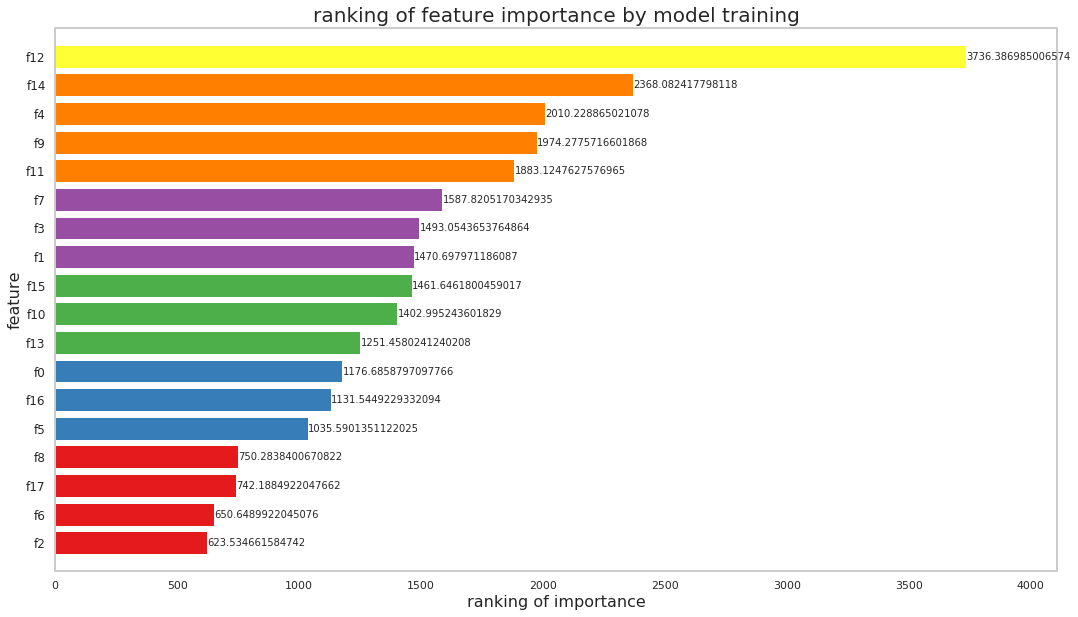

In [84]:
# determine the importance of feature
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# plot the importance of features
colours = plt.cm.Set1(np.linspace(0, 1, 30))
fig = plt.figure(figsize = (16, 10))
ax = fig.add_subplot(111)
ax = xgb.plot_importance(model,
                         height = 0.8,
                         color = colours,
                         grid = False,
                         show_values = True,
                         importance_type = 'cover',
                         ax = ax)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

ax.set_xlabel('ranking of importance', size = 16)
ax.set_ylabel('feature', size = 16)
ax.set_yticklabels(ax.get_yticklabels(), size = 12)
ax.set_title('ranking of feature importance by model training', size = 20)

In [82]:
plt.figure(figsize = (12, 8))
# os.environ['PATH'] += os.pathsep + 'D:/Graphviz2.38/bin'
xgb.to_graphviz(model)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

<Figure size 864x576 with 0 Axes>

In [92]:
# 学习曲线显示精度
from sklearn.model_selection import train_test_split, learning_curve
trainSizes, trainScores, crossValScores = learning_curve(
    xgb.XGBClassifier(silent = 1,
                      #scale_pos_weight = weights,
                      n_jobs = -1,
                      eval_metric = 'auc',
                      n_estimators = 100,
                      max_depth = 9,
                      min_child_weight = min_child_weight,
                      subsample = subsample,
                      colsample_bytree = colsample_bytree,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      seed = seed
                     ),
    X_train_new,
    Y_train_new,
    cv = 5,
    scoring = 'accuracy'
)

Text(0.5,1,'Learning Curves (70% samples)')

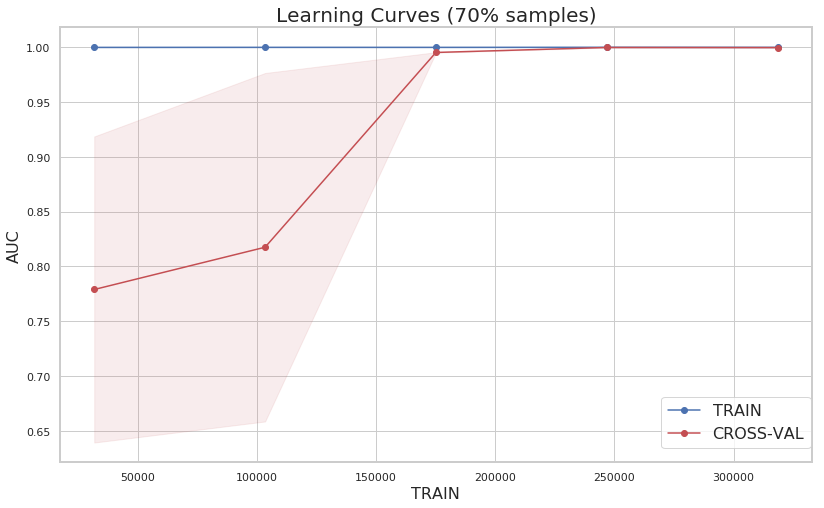

In [93]:
trainScoresMean = np.mean(trainScores, axis = 1)
trainScoresStd = np.std(trainScores, axis = 1)
crossValScoresMean = np.mean(crossValScores, axis = 1)
crossValScoresStd = np.std(crossValScores, axis = 1)

fig = plt.figure(figsize = (12, 8))
plt.fill_between(trainSizes,
                 trainScoresMean - trainScoresStd,
                 trainScoresMean + trainScoresStd,
                 alpha = 0.1,
                 color = 'b')
plt.fill_between(trainSizes,
                 crossValScoresMean - crossValScoresStd,
                 crossValScoresMean + crossValScoresStd,
                 alpha = 0.1,
                 color = 'r')
plt.plot(trainSizes,
         trainScores.mean(axis = 1),
         'o-',
         label = 'TRAIN',
         color = 'b')
plt.plot(trainSizes,
         crossValScores.mean(axis = 1),
         'o-',
         label = 'CROSS-VAL',
         color = 'r')

ax = plt.gca()
for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles,
           ['TRAIN', 'CROSS-VAL'],
           bbox_to_anchor = (0.8, 0.15),
           loc = 2,
           borderaxespad = 0,
           fontsize = 16)
plt.xlabel('TRAIN', size = 16)
plt.ylabel('AUC', size = 16)
plt.title('Learning Curves (70% samples)', size = 20)